In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.utils import shuffle

In [2]:
# Dataset
!wget -nc http://files.grouplens.org/datasets/movielens/ml-20m.zip

--2021-06-05 21:11:15--  http://files.grouplens.org/datasets/movielens/ml-20m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 198702078 (189M) [application/zip]
Saving to: ‘ml-20m.zip’

ml-20m.zip          100%[===================>] 189.50M  71.7MB/s    in 2.6s    

2021-06-05 21:11:18 (71.7 MB/s) - ‘ml-20m.zip’ saved [198702078/198702078]



In [3]:
!unzip -n ml-20m.zip

Archive:  ml-20m.zip
   creating: ml-20m/
  inflating: ml-20m/genome-scores.csv  
  inflating: ml-20m/genome-tags.csv  
  inflating: ml-20m/links.csv        
  inflating: ml-20m/movies.csv       
  inflating: ml-20m/ratings.csv      
  inflating: ml-20m/README.txt       
  inflating: ml-20m/tags.csv         


In [4]:
!ls

__notebook__.ipynb  ml-20m  ml-20m.zip


In [5]:
df = pd.read_csv('ml-20m/ratings.csv')
df.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [6]:
# Creating our new ids for the userId
df.userId = pd.Categorical(df.userId)
df['new_user_id'] = df.userId.cat.codes

# same for movieId
df.movieId = pd.Categorical(df.movieId)
df['new_movie_id'] = df.movieId.cat.codes

In [7]:
# Get user IDs, movie IDs and ratings as separate arrays
user_ids = df['new_user_id'].values
movie_ids = df['new_movie_id'].values
ratings = df['rating'].values - 2.5  # shifting

In [8]:
# Get number of users and number of movies
N = len(set(user_ids))
M = len(set(movie_ids))

# Set embedding dimension
D = 10

In [9]:
# Model
class Model(nn.Module):

    def __init__(self, n_users, n_items, embed_dim, n_hidden=1024):

        super(Model, self).__init__()
        self.N = n_users
        self.M = n_items
        self.D = embed_dim

        self.u_emb = nn.Embedding(self.N, self.D)
        self.m_emb = nn.Embedding(self.M, self.D)
        self.fc1 = nn.Linear(2*self.D, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)

    def forward(self, u, m):

        # N --> N X D
        u = self.u_emb(u)
        m = self.m_emb(m)

        # merge the two networks
        # (out) : N X 2D
        out = torch.cat((u, m), 1)

        # ANN
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        return out


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [11]:
model = Model(n_users=N, n_items=M, embed_dim=D)
model.to(device)

Model(
  (u_emb): Embedding(138493, 10)
  (m_emb): Embedding(26744, 10)
  (fc1): Linear(in_features=20, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=1, bias=True)
)

In [12]:
# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())

In [13]:
# shuffle the data in corresponding order
user_ids, movie_ids, ratings = shuffle(user_ids, movie_ids, ratings)

In [14]:
# convert to tensors
user_ids_t = torch.from_numpy(user_ids).long()
movie_ids_t = torch.from_numpy(movie_ids).long()
ratings_t = torch.from_numpy(ratings)

In [15]:
# Make datasets
Ntrain = int(0.8 * len(ratings))

train_dataset = torch.utils.data.TensorDataset(
    user_ids_t[:Ntrain],
    movie_ids_t[:Ntrain],
    ratings_t[:Ntrain]
)

test_dataset = torch.utils.data.TensorDataset(
    user_ids_t[Ntrain:],
    movie_ids_t[Ntrain:],
    ratings_t[Ntrain:]
)

In [16]:
# Data Loaders
batch_size = 512
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [17]:
# Training loop

def batch_gd(model, criterion, optimizer, train_iter, test_iter, epochs):

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)

    for it in range(epochs):

        t0 = datetime.now()
        train_loss = []

        for users, movies, targets in train_loader:

            targets = targets.view(-1, 1).float()

            # move data to gpu
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)

            optimizer.zero_grad()

            # forward pass
            outputs = model(users, movies)
            loss = criterion(outputs, targets)

            # Backward and optimize
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())

        train_loss = np.mean(train_loss)

        test_loss = []
        for users, movies, targets in test_loader:
            users, movies, targets = users.to(device), movies.to(device), targets.to(device)
            targets = targets.view(-1, 1).float()
            outputs = model(users, movies)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        
        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, '
            f'Test Loss: {test_loss:.4f}, Duration: {dt}')
    
    return train_losses, test_losses

In [18]:
train_losses, test_losses = batch_gd(
model, criterion, optimizer, train_loader, test_loader, 25)

Epoch 1/25, Train Loss: 0.8175, Test Loss: 0.7521, Duration: 0:05:05.621893
Epoch 2/25, Train Loss: 0.7396, Test Loss: 0.7366, Duration: 0:05:05.219322
Epoch 3/25, Train Loss: 0.7239, Test Loss: 0.7242, Duration: 0:05:02.747843
Epoch 4/25, Train Loss: 0.7092, Test Loss: 0.7133, Duration: 0:05:01.719211
Epoch 5/25, Train Loss: 0.6971, Test Loss: 0.7044, Duration: 0:05:02.009239
Epoch 6/25, Train Loss: 0.6886, Test Loss: 0.7007, Duration: 0:05:02.245273
Epoch 7/25, Train Loss: 0.6826, Test Loss: 0.6964, Duration: 0:05:08.428504
Epoch 8/25, Train Loss: 0.6782, Test Loss: 0.6954, Duration: 0:05:04.655931
Epoch 9/25, Train Loss: 0.6747, Test Loss: 0.6919, Duration: 0:05:03.056524
Epoch 10/25, Train Loss: 0.6716, Test Loss: 0.6922, Duration: 0:05:02.562068
Epoch 11/25, Train Loss: 0.6689, Test Loss: 0.6912, Duration: 0:05:02.917202
Epoch 12/25, Train Loss: 0.6663, Test Loss: 0.6886, Duration: 0:05:05.241486
Epoch 13/25, Train Loss: 0.6640, Test Loss: 0.6881, Duration: 0:05:03.542269
Epoch 14

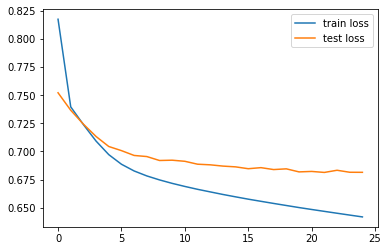

In [19]:
# Plot the train loss and test loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.show()